In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module="jupyter_client.session"
)

!pip install mlxtend==0.23.1

**LOAD DATASET**

In [2]:
#Load dataset dari Github
url = "https://raw.githubusercontent.com/Richoivan/Datamining_Richoivan/main/bank.csv"
df = pd.read_csv(url)

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


**Exploratory Data Analysis (EDA)**

With the dataset loaded, I transition into Exploratory Data Analysis (EDA). This phase is crucial for understanding the data better and identifying patterns.

Data Overview
I begin by checking for missing values and summarizing the basic statistics of the dataset.

In [3]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
#check missing values
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


Berdasarkan hasil pengecekan missing value, seluruh atribut dalam dataset memiliki nilai lengkap tanpa data hilang. Oleh karena itu, tidak diperlukan proses penanganan missing value, dan tahap data preparation dapat difokuskan pada transformasi data yang relevan untuk Association Rules Mining.

In [5]:
# Copy dataframe
df_bin = df.copy()

# Binning kolom numerik
df_bin['age_group'] = pd.cut(
    df_bin['age'],
    bins=[0, 30, 45, 60, 100],
    labels=['young', 'adult', 'middle_age', 'senior']
)

df_bin['balance_group'] = pd.cut(
    df_bin['balance'],
    bins=[-float('inf'), 0, 1000, float('inf')],
    labels=['low', 'medium', 'high']
)

df_bin['campaign_group'] = pd.cut(
    df_bin['campaign'],
    bins=[0, 2, 5, float('inf')],
    labels=['few', 'medium', 'many']
)

df_bin['pdays_group'] = df_bin['pdays'].apply(
    lambda x: 'not_contacted' if x == -1 else 'contacted_before'
)

df_bin['previous_group'] = df_bin['previous'].apply(
    lambda x: 'no_previous_contact' if x == 0 else 'previous_contact'
)

# Preview hasil binning
df_bin[['age_group', 'balance_group', 'campaign_group',
        'pdays_group', 'previous_group']].head()


,age_group,balance_group,campaign_group,pdays_group,previous_group
0,middle_age,high,few,not_contacted,no_previous_contact
1,middle_age,medium,few,not_contacted,no_previous_contact
2,adult,high,few,not_contacted,no_previous_contact
3,middle_age,high,few,not_contacted,no_previous_contact
4,middle_age,medium,few,not_contacted,no_previous_contact


Binning dilakukan untuk mengubah atribut numerik menjadi kategori agar dapat diperlakukan sebagai item dalam Association Rules Mining. Selain itu, binning membantu menyederhanakan data, mengurangi kompleksitas nilai numerik, dan memudahkan interpretasi pola keterkaitan antar karakteristik nasabah.

**Customer Profile Patterns**

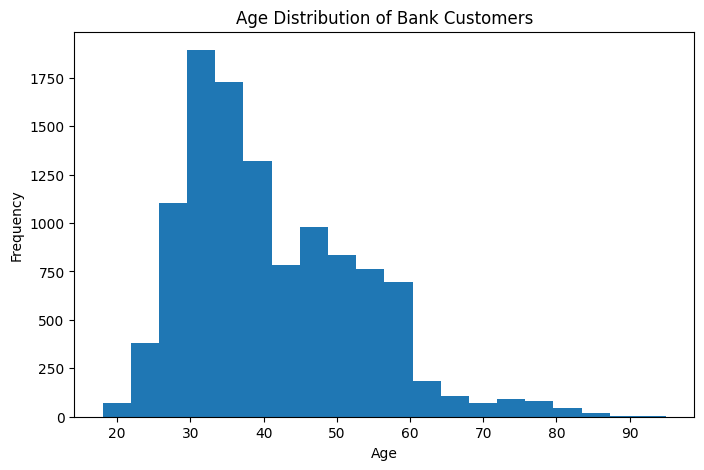

In [6]:
#Histogram Age
plt.figure(figsize=(8,5))
plt.hist(df['age'], bins=20)
plt.title('Age Distribution of Bank Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


Visualisasi distribusi usia menunjukkan bahwa sebagian besar nasabah bank berada pada rentang usia produktif, khususnya antara 25 hingga 45 tahun. Frekuensi nasabah menurun seiring bertambahnya usia, dengan jumlah nasabah usia lanjut relatif lebih sedikit. Pola ini mengindikasikan bahwa layanan dan kampanye pemasaran bank lebih banyak menjangkau kelompok usia produktif, yang berpotensi memiliki aktivitas finansial lebih tinggi.

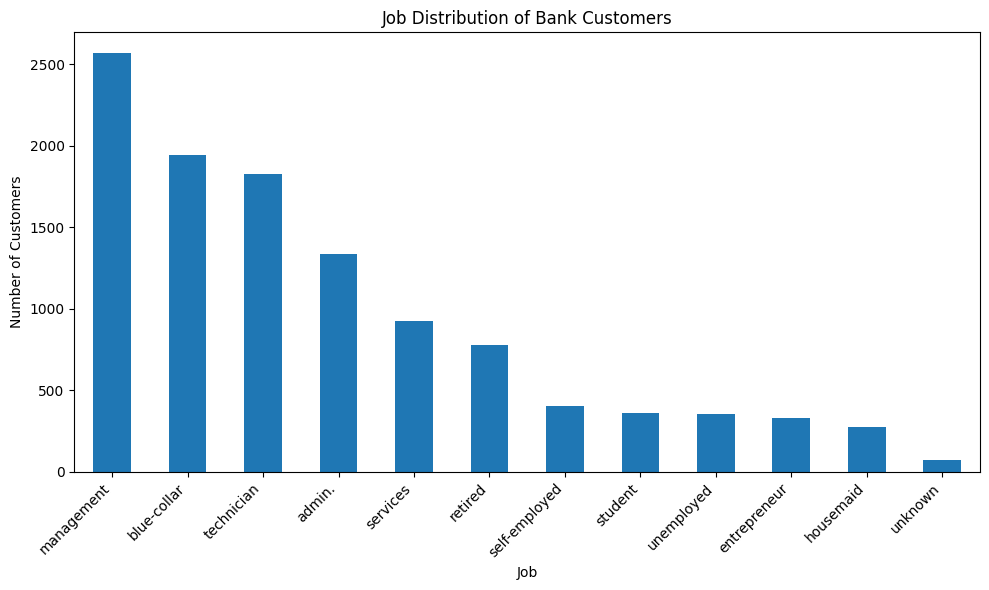

In [7]:
# BAR CHART JOB DISTRIBUTION
job_counts = df['job'].value_counts()

plt.figure(figsize=(10,6))
job_counts.plot(kind='bar')
plt.title('Job Distribution of Bank Customers')
plt.xlabel('Job')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Visualisasi ini menunjukkan bahwa sebagian besar nasabah bank berasal dari kategori pekerjaan management, blue-collar, dan technician. Sementara itu, kategori pekerjaan seperti housemaid dan unknown memiliki jumlah nasabah yang relatif sedikit. Distribusi ini menggambarkan bahwa basis nasabah bank didominasi oleh kelompok pekerjaan tertentu, yang berpotensi memengaruhi pola keterkaitan karakteristik nasabah dalam analisis Association Rules Mining.

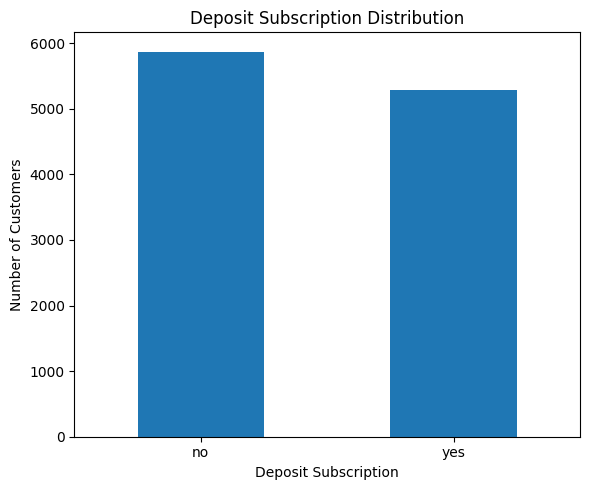

In [8]:
#Deposit Subscription Distribution

deposit_counts = df['deposit'].value_counts()

plt.figure(figsize=(6,5))
deposit_counts.plot(kind='bar')
plt.title('Deposit Subscription Distribution')
plt.xlabel('Deposit Subscription')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Visualisasi ini menunjukkan bahwa jumlah nasabah yang tidak berlangganan deposito lebih besar dibandingkan nasabah yang berlangganan. Informasi ini penting sebagai gambaran awal sebelum dilakukan Association Rules Mining, khususnya dalam menganalisis pola keterkaitan karakteristik nasabah yang berpotensi memengaruhi keputusan berlangganan deposito.

**ENCODING**

In [9]:
# Salin data hasil binning
df_transactions = df_bin.copy()

# Kolom yang digunakan untuk Association Rules
cols_for_association = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'poutcome', 'deposit',
    'age_group', 'balance_group', 'campaign_group',
    'pdays_group', 'previous_group'
]

# One-Hot Encoding (Transaction Matrix)
df_transactions = pd.get_dummies(
    df_transactions[cols_for_association],
    prefix_sep='='
).astype(bool)

# Preview hasil
df_transactions.head()


,job=admin.,job=blue-collar,job=entrepreneur,job=housemaid,job=management,job=retired,job=self-employed,job=services,job=student,job=technician,...,balance_group=low,balance_group=medium,balance_group=high,campaign_group=few,campaign_group=medium,campaign_group=many,pdays_group=contacted_before,pdays_group=not_contacted,previous_group=no_previous_contact,previous_group=previous_contact
0,True,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,True,True,False
1,True,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,True,True,False,False,False,True,True,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,True,True,False,False,False,True,True,False
4,True,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,True,True,False


## **Applying the Apriori Algorithm**
With a solid understanding of the data, I shift my focus to identifying associations between items using the Apriori algorithm.

### **Data Preparation for Apriori**
I need to transform the dataset into a format suitable for the Apriori algorithm, where each transaction is represented as a row and each item as a column.

In [10]:
# Membuat basket (Transaction × Item) untuk Association Rule Mining
# Menggunakan hasil one-hot encoding (boolean)

basket = df_transactions.copy()

basket.head()


,job=admin.,job=blue-collar,job=entrepreneur,job=housemaid,job=management,job=retired,job=self-employed,job=services,job=student,job=technician,...,balance_group=low,balance_group=medium,balance_group=high,campaign_group=few,campaign_group=medium,campaign_group=many,pdays_group=contacted_before,pdays_group=not_contacted,previous_group=no_previous_contact,previous_group=previous_contact
0,True,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,True,True,False
1,True,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,True,True,False,False,False,True,True,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,True,True,False,False,False,True,True,False
4,True,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,True,True,False


In [11]:

frequent_itemsets = apriori(
    basket,
    min_support=0.02,
    use_colnames=True
)

frequent_itemsets


,support,itemsets
0,0.119513,(job=admin.)
1,0.174162,(job=blue-collar)
2,0.029385,(job=entrepreneur)
3,0.024548,(job=housemaid)
4,0.229887,(job=management)
...,...,...
136685,0.021502,"(loan=no, campaign_group=few, month=may, conta..."
136686,0.020068,"(loan=no, campaign_group=few, month=may, conta..."
136687,0.020337,"(marital=married, loan=no, campaign_group=few,..."
136688,0.020337,"(marital=married, loan=no, campaign_group=few,..."


In [12]:
# Batasi panjang itemset
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] <= 2]

# Association Rules
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1
)

rules.sort_values(by='lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
121,(job=retired),(age_group=senior),0.069701,0.054739,0.041301,0.592545,10.824856,0.037485,2.319914,0.975622
120,(age_group=senior),(job=retired),0.054739,0.069701,0.041301,0.754501,10.824856,0.037485,3.789419,0.960180
178,(job=student),(age_group=young),0.032252,0.179806,0.027325,0.847222,4.711856,0.021526,5.368539,0.814024
179,(age_group=young),(job=student),0.179806,0.032252,0.027325,0.151968,4.711856,0.021526,1.141169,0.960468
933,(pdays_group=contacted_before),(previous_group=previous_contact),0.254256,0.254256,0.254256,1.000000,3.933051,0.189610,inf,1.000000
932,(previous_group=previous_contact),(pdays_group=contacted_before),0.254256,0.254256,0.254256,1.000000,3.933051,0.189610,inf,1.000000
806,(poutcome=other),(previous_group=previous_contact),0.048110,0.254256,0.048110,1.000000,3.933051,0.035878,inf,0.783435
804,(poutcome=other),(pdays_group=contacted_before),0.048110,0.254256,0.048110,1.000000,3.933051,0.035878,inf,0.783435
795,(poutcome=failure),(pdays_group=contacted_before),0.110016,0.254256,0.110016,1.000000,3.933051,0.082044,inf,0.837930
794,(pdays_group=contacted_before),(poutcome=failure),0.254256,0.110016,0.110016,0.432699,3.933051,0.082044,1.568804,1.000000


Key Insights from Association Rules Analysis

Terdapat hubungan yang sangat kuat antara usia dan status pekerjaan nasabah.
Nasabah dengan status pekerjaan retired sangat dominan berada pada kelompok usia senior, yang ditunjukkan oleh nilai confidence dan lift yang tinggi.

Segmen nasabah muda memiliki karakteristik yang jelas.
Nasabah dengan pekerjaan student sebagian besar berada pada kelompok usia young, membentuk segmen pelanggan muda yang konsisten.

Pola riwayat kontak nasabah bersifat sangat konsisten.
Nasabah yang pernah dihubungi sebelumnya selalu memiliki catatan kontak sebelumnya, menunjukkan keteraturan dalam proses pemasaran bank.

Hasil kampanye sebelumnya berkaitan erat dengan riwayat kontak.
Nasabah dengan hasil kampanye failure atau other umumnya merupakan nasabah yang telah dihubungi sebelumnya, mencerminkan upaya tindak lanjut yang berulang.

Secara keseluruhan, karakteristik nasabah membentuk pola yang jelas dan tidak acak.
Pola-pola ini dapat dimanfaatkan untuk meningkatkan segmentasi nasabah, menargetkan kampanye pemasaran secara lebih efektif, serta mengoptimalkan strategi komunikasi bank.

